<a href="https://colab.research.google.com/github/CristianCosci/Generative_Adversarial_Networks_GAN__Overview/blob/master/GAN/notebooks/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image

import numpy as np
import datetime
import os, sys

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, imsave
%matplotlib inline

from tqdm import tqdm
import glob
from PIL import Image

### **Google Drive linking and other operations for saving some data**

In [2]:
from google.colab import drive
drive.mount('/content/drive')
PATH_DRIVE = '/content/drive/My Drive/UNIMORE/GAN' # Path on Google Drive where to save data (trained models and generation samples)

Mounted at /content/drive


In [3]:
verbose = False
torch.manual_seed(1)
NOISE_VECTOR_DIM = 100
MODEL_NAME = 'VanillalGAN'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if not os.path.exists(PATH_DRIVE + '/samples'):
  os.makedirs(PATH_DRIVE + '/samples')

if not os.path.exists(PATH_DRIVE + '/samples/gif_dir'):
  os.makedirs(PATH_DRIVE + '/samples/gif_dir')

if not os.path.exists(PATH_DRIVE + '/training_models'):
  os.makedirs(PATH_DRIVE + '/training_models')

if not os.path.exists(PATH_DRIVE + '/training_models/Discriminator'):
  os.makedirs(PATH_DRIVE + '/training_models/Discriminator')

if not os.path.exists(PATH_DRIVE + '/training_models/Generator'):
  os.makedirs(PATH_DRIVE + '/training_models/Generator')

# **Project start**

In [4]:
def get_sample_images(G, num_samples):
  '''
  Generate num_samples noise vector from latent space and pass to Generator
  as input in order to get sample images.

  returns:
    num_samples generate images
  '''
  assert int(np.sqrt(num_samples)) * int(np.sqrt(num_samples)) == num_samples  , "num_samples square is not integer"

  z = torch.randn(num_samples, NOISE_VECTOR_DIM).to(DEVICE)  #z.shape = torch.Size([num_samples, 100])
  y_hat = G(z).view(num_samples, 28, 28) # (100, 28, 28)
  samples_img = y_hat.cpu().data.numpy()

  #Put generated samples in a matrix of size sqrt(num_samples) x sqrt(num_samples)
  #in order to plot all samples togheter
  samples_per_line = int(np.sqrt(num_samples))
  matrix_img = np.zeros([28 * samples_per_line, 28 * samples_per_line])
  for j in range(samples_per_line): 
    matrix_img[j*28:(j+1)*28] = np.concatenate([x for x in samples_img[j*samples_per_line:(j+1)*samples_per_line]], axis=-1)
      
  return matrix_img


def make_gif(frame_folder, duration):
  '''
  Make a gif from generated samples during the training in order to see
  the improvement of the generator.

  returns:
    save a gif on google drive directory
  '''
  a = [image for image in glob.glob(f"{frame_folder}/*.jpg")]
  imgs = [Image.open(image) for image in glob.glob(f"{frame_folder}/*.jpg")]
  for i in range(len(imgs)):
    plt.imshow(imgs[i], cmap='gray')
    plt.axis('off')
    plt.title('epoch: {}'.format(int(i* 200/len(imgs))))
    plt.savefig(frame_folder + 'gif_dir/img_%d.jpg' % int(i* 200/len(imgs)))


  a = [image for image in glob.glob(f"{frame_folder + '/gif_dir'}/*.jpg")]
  frames = [Image.open(image) for image in glob.glob(f"{frame_folder + '/gif_dir'}/*.jpg")]
  print('frames: {}'.format(len(frames)))
  frame_one = frames[0]
  frame_one.save(PATH_DRIVE + "/training_improvements.gif", format="GIF",
              append_images=frames, save_all=True, duration=duration, loop=0)

### **Dataset loading and preparation**

In [ ]:
#MNIST dataset preparation
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5],
                                std=[0.5])]
                              )

mnist = datasets.MNIST(root='../data/', train=True, transform=transform, download=True)
batch_size = 64
data_loader = DataLoader(dataset=mnist, batch_size=batch_size, shuffle=True, drop_last=True)

**Leaky ReLU and Batch Normalization**
<hr>

**Leaky ReLU** is a type of activation function that helps to prevent the function from becoming saturated at 0. It has a small slope instead of the standard ReLU which has an infinite slope. <br>
Leaky ReLU is a modification of the ReLU activation function. It has the same form as the ReLU, but it will leak some positive values to 0 if they are close enough to zero. It uses leaky values to avoid dividing by zero when the input value is negative, which can happen with standard ReLU when training neural networks with gradient descent.
<hr>

**Batch normalization** (also known as batch norm) is a method used to make training of artificial neural networks faster and more stable through normalization of the layers' inputs by re-centering and re-scaling.

In [ ]:
class Generator(nn.Module):
  '''
  Generator model definition.
  In the Vanilla GAN it is defined as an MLP model with input size equal to noise vector.
  The output size is the same as images we want to generate.
  '''
  def __init__(self, input_size=NOISE_VECTOR_DIM, output_size=784):
    super(Generator, self).__init__()

    self.model = nn.Sequential(
      nn.Linear(input_size, 128),
      nn.LeakyReLU(0.2, inplace=True),
      nn.Linear(128, 256),
      nn.BatchNorm1d(256),
      nn.LeakyReLU(0.2, inplace=True),
      nn.Linear(256, 512),
      nn.BatchNorm1d(512),
      nn.LeakyReLU(0.2, inplace=True),
      nn.Linear(512, 1024),
      nn.BatchNorm1d(1024),
      nn.LeakyReLU(0.2, inplace=True),
      nn.Linear(1024, output_size),
      nn.Tanh() #The tanh activation at the output layer ensures that the pixel 
                #values are mapped in line with its own output, i.e., between (-1, 1)
      )
      

  def forward(self, noise_vector):
    generated_img = self.model(noise_vector)
    generated_img = generated_img.view(generated_img.size(0), 1, 28, 28)
    return generated_img

In [ ]:
class Discriminator(nn.Module):
  '''
  Discriminator model definition as a binary classifier.
  In the Vanilla GAN it is defined as an MLP model with input size equal to
  flattened image size.
  The output size is the 1 (i.e. the probability of a binary problem -> real or fake).
  '''
  def __init__(self, input_size=784, num_classes=1):
    super(Discriminator, self).__init__()

    self.model = nn.Sequential(
      nn.Linear(input_size, 512),
      nn.LeakyReLU(0.2, inplace=True),
      nn.Linear(512, 256),
      nn.LeakyReLU(0.2, inplace=True),
      nn.Linear(256, num_classes),
      nn.Sigmoid(), #The final layer has the sigmoid activation function, 
                    #which squashes the output value between 0 (fake) and 1 (real).
      )


  def forward(self, image):
    image_flattened = image.view(image.size(0), -1)
    result = self.model(image_flattened)
    return result

## **Training phase**

In [ ]:
#Models creation
num_samples = 100
D = Discriminator().to(DEVICE)
G = Generator().to(DEVICE)

#Loss function
adversarial_loss  = nn.BCELoss()

#Optimizer
D_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
G_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))


In [ ]:
max_epoch = 200 # epochs for training
step = 0
step_frequency = 10000 #frequency to save training samples in order to see G's improvements
n_critic = 1 # for training more k steps about Discriminator

D_loss_history = []
G_loss_history = []

D_labels = torch.ones(batch_size, 1).to(DEVICE) # Discriminator Label to real
D_fakes = torch.zeros(batch_size, 1).to(DEVICE) # Discriminator Label to fake

for epoch in tqdm(range(max_epoch), desc='GAN training'):
  for idx, (real_images, _) in enumerate(data_loader):
    # Training Discriminator
    x = real_images.to(DEVICE)
    x_outputs = D(x)
    D_x_loss = adversarial_loss(x_outputs, D_labels)

    # noise vector sampled from a normal distribution
    z = torch.randn(batch_size, NOISE_VECTOR_DIM).to(DEVICE)
    z_outputs = D(G(z))
    D_z_loss = adversarial_loss(z_outputs, D_fakes)
    D_loss = D_x_loss + D_z_loss
    
    D.zero_grad()
    D_loss.backward()
    D_optimizer.step()

    if step % n_critic == 0:
      # Training Generator
      z = torch.randn(batch_size, NOISE_VECTOR_DIM).to(DEVICE)
      z_outputs = D(G(z))
      G_loss = adversarial_loss(z_outputs, D_labels)

      G.zero_grad()
      G_loss.backward()
      G_optimizer.step()
    
    if verbose:
      if step % 500 == 0:
        print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}'.format(epoch, max_epoch, step, D_loss.item(), G_loss.item()))
    
    if step % step_frequency == 0:
      G.eval()
      img = get_sample_images(G, num_samples)
      imsave(PATH_DRIVE + '/samples/{}_step{}.jpg'.format(MODEL_NAME, str(step).zfill(3)), img, cmap='gray')
      G.train()

    step += 1
    
  D_loss_history.append(D_loss.item())
  G_loss_history.append(G_loss.item())

  torch.save(G.state_dict(), PATH_DRIVE + '/training_models/Generator/G_epoch_%d.pth' % (epoch))
  torch.save(D.state_dict(), PATH_DRIVE + '/training_models/Discriminator/D_epoch_%d.pth' % (epoch))

GAN training: 100%|██████████| 200/200 [58:30<00:00, 17.55s/it]


## **Post training operations**

### **Plotting Generator and Discriminator's losses**

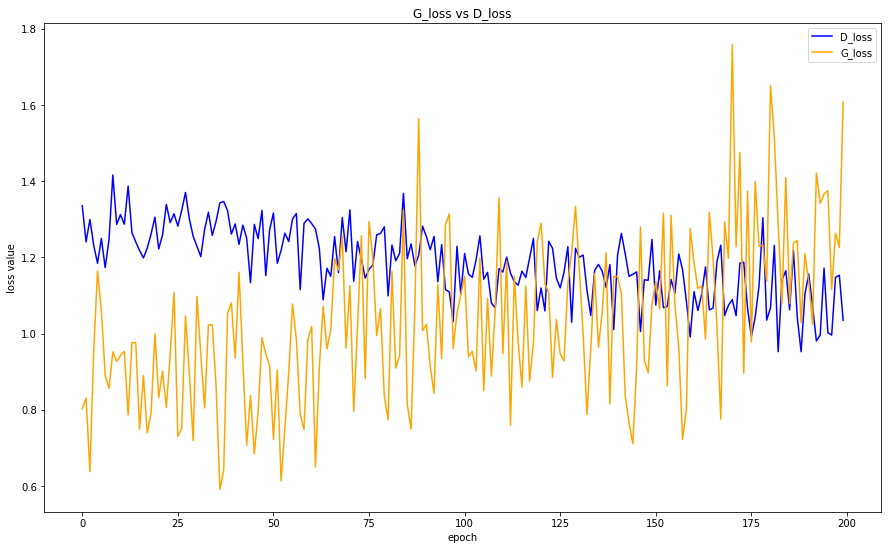

In [ ]:
plt.figure(figsize=(15,9)) 
plt.plot(D_loss_history, color='blue', label='D_loss') #plot the data
plt.plot(G_loss_history, color='orange', label='G_loss') #plot the data
plt.ylabel('loss value') #set the label for y axis
plt.xlabel('epoch') #set the label for x-axis
plt.title("G_loss vs D_loss") #set the title of the graph
plt.legend()
plt.show() #display the graph

### **Plotting some sample images**

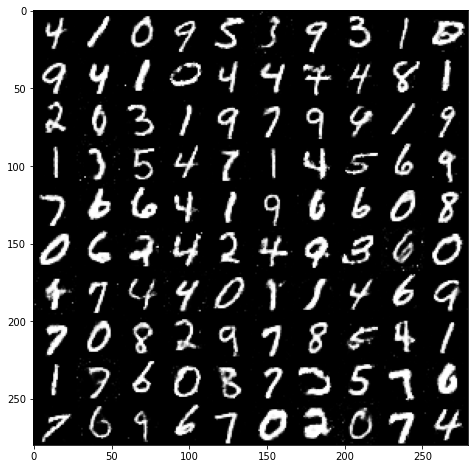

In [ ]:
# generation to image
G.eval()
plt.figure(figsize=(8,8)) 
imshow(get_sample_images(G, num_samples), cmap='gray')

In [ ]:
# Saving params
min_value = min(G_loss_history)
min_index = G_loss_history.index(min_value)
print(min_index)  #to see at which epoch the Generator has te lowest loss

# Saving models at last epoch of training
torch.save(D.state_dict(), PATH_DRIVE + '/training_models/Discriminator/Discriminator.pth')
torch.save(G.state_dict(), PATH_DRIVE + '/training_models/Generator/Generator.pth')

36


### **Loading model using pytorch**

In [ ]:
G.load_state_dict(torch.load(PATH_DRIVE + '/training_models/Generator/Generator.pth'), strict=False)
G.eval()

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Linear(in_features=1024, out_features=784, bias=True)
    (12): Tanh()
  )
)

### **Making a gif to see Generator's improvement during training**

frames: 19


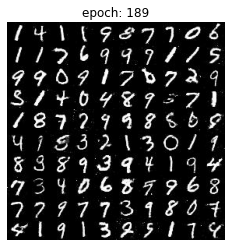

In [5]:
make_gif(PATH_DRIVE + '/samples/', 250)